In [1]:
import os
import sys
import math
import time
import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import nibabel as nib
from scipy import sparse
from scipy.stats import spearmanr
from sklearn import preprocessing, metrics,manifold
from sklearn.model_selection import cross_val_score, train_test_split,ShuffleSplit
from nilearn import connectome
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch_sparse import spmm
from torch_scatter import scatter_add
from torch_geometric.utils import add_self_loops

import warnings
warnings.filterwarnings(action='once')

(array([123924.,   1848.,    856.,    444.,    316.,    268.,    200.,
           224.,    158.,    168.]),
 array([0.        , 0.09998608, 0.19997216, 0.29995824, 0.39994433,
        0.49993041, 0.59991649, 0.69990257, 0.79988865, 0.89987473,
        0.99986081]),
 <a list of 10 Patch objects>)

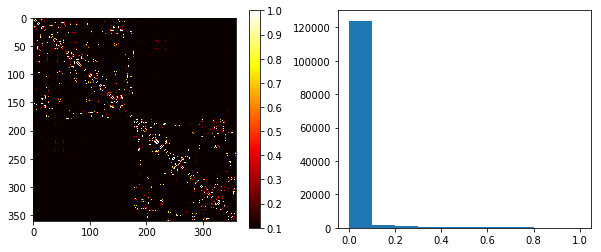

In [3]:
##step1: load brain connectome
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

adjacent_mat_file = "../data/brain_graph/MMP_DiffusionConnectivity_HCP_avg56.mat"
mat = scipy.io.loadmat(adjacent_mat_file)
corr_matrix_z = mat['SC_avg56']
num_nodes = corr_matrix_z.shape[0]

fig=plt.figure(figsize=(10,4))
fig.add_subplot(121)
plt.imshow(corr_matrix_z, cmap="hot",vmin=0.1, vmax=1)
plt.colorbar()

fig.add_subplot(122)
plt.hist(corr_matrix_z[corr_matrix_z<1])

/home/yzhang/miniconda3/envs/tensorflow-py3.6/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(array([2118.,  234.,  172.,  166.,  170.,  148.,  156.,  122.,  156.,
          92.]),
 array([6.14701167e-270, 1.00000000e-001, 2.00000000e-001, 3.00000000e-001,
        4.00000000e-001, 5.00000000e-001, 6.00000000e-001, 7.00000000e-001,
        8.00000000e-001, 9.00000000e-001, 1.00000000e+000]),
 <a list of 10 Patch objects>)

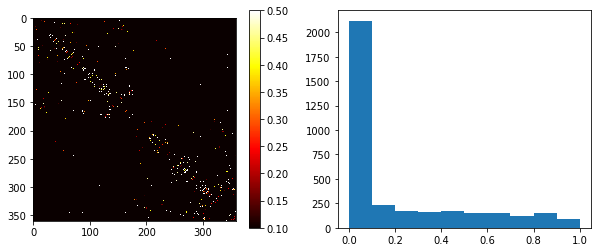

In [4]:
## Step2: build a k-NN graph.

def build_adjacency(dist, idx):
    """Return the adjacency matrix of a kNN graph."""
    M, k = dist.shape
    assert M, k == idx.shape
    assert dist.min() >= 0

    # Weights.
    sigma2 = np.mean(dist[:, -1])**2
    dist = np.exp(- dist**2 / sigma2)

    # Weight matrix.
    I = np.arange(0, M).repeat(k)
    J = idx.reshape(M*k)
    V = dist.reshape(M*k)
    W = sparse.coo_matrix((V, (I, J)), shape=(M, M))

    # No self-connections.
    W.setdiag(0)

    # Non-directed graph.
    bigger = W.T > W
    W = W - W.multiply(bigger) + W.T.multiply(bigger)
    return W

Nneighbours=8
idx = np.argsort(-corr_matrix_z)[:, 1:Nneighbours + 1]
dist = np.array([corr_matrix_z[i, idx[i]] for i in range(corr_matrix_z.shape[0])])
dist[dist < 0.1] = 0
adj_mat_sp = build_adjacency(dist, idx)

fig=plt.figure(figsize=(10,4))
fig.add_subplot(121)
plt.imshow(adj_mat_sp.todense(), cmap="hot",vmin=0.1, vmax=0.5);
plt.colorbar()

fig.add_subplot(122)
plt.hist(adj_mat_sp.data)


Converting from scipy sparse matrix:
[  2   4   5 ... 248 343 358]
[1.20991668e-02 2.25504229e-74 2.70600250e-04 ... 4.19549925e-02
 5.11535778e-01 7.31470842e-12]
Converting to torch sparse tensor:
tensor([[  2,   4,   5,  ..., 248, 343, 358],
        [  0,   0,   0,  ..., 359, 359, 359]])
tensor([1.2099e-02, 0.0000e+00, 2.7060e-04,  ..., 4.1955e-02, 5.1154e-01,
        7.3147e-12])


(array([ 360.,    0.,    0.,    0.,    0., 2186.,  932.,  338.,   68.,
          10.]),
 array([-1.        , -0.81988215, -0.63976437, -0.45964652, -0.27952868,
        -0.09941086,  0.08070697,  0.2608248 ,  0.44094262,  0.62106043,
         0.8011783 ], dtype=float32),
 <a list of 10 Patch objects>)

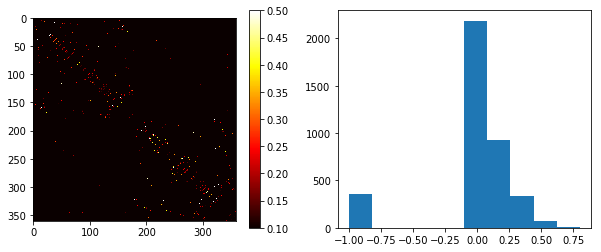

In [5]:
###Step 3: Laplacian Matrix: L=I-D(-1/2)AD(-1/2)
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

adj_mat = sparse_mx_to_torch_sparse_tensor(adj_mat_sp)
print("Converting from scipy sparse matrix:")
print(adj_mat_sp.indices)
print(adj_mat_sp.data)
print("Converting to torch sparse tensor:")
print(adj_mat._indices())
print(adj_mat._values())

edge_index = adj_mat._indices()
edge_weight = adj_mat._values()
row, col = edge_index
        
#degree-matrix
deg = scatter_add(edge_weight, row, dim=0, dim_size=num_nodes)

# Compute normalized and rescaled Laplacian.
deg = deg.pow(-0.5)
deg[torch.isinf(deg)] = 0
lap = deg[row] * edge_weight * deg[col]

###Rescale the Laplacian eigenvalues in [-1, 1]
##rescale: 2L/lmax-I; lmax=1.0
fill_value = 1  ##-0.5
edge_index, lap = add_self_loops(edge_index, -lap, fill_value, num_nodes)

laplacian_matrix = sparse.coo_matrix((lap.numpy(),edge_index),shape=(num_nodes,num_nodes))
fig=plt.figure(figsize=(10,4))
fig.add_subplot(121)
plt.imshow(-laplacian_matrix.todense(), cmap="hot",vmin=0.1, vmax=0.5);
plt.colorbar()

fig.add_subplot(122)
plt.hist(-laplacian_matrix.data)

Text(0.5, 1.0, '2nd EigenVectors')

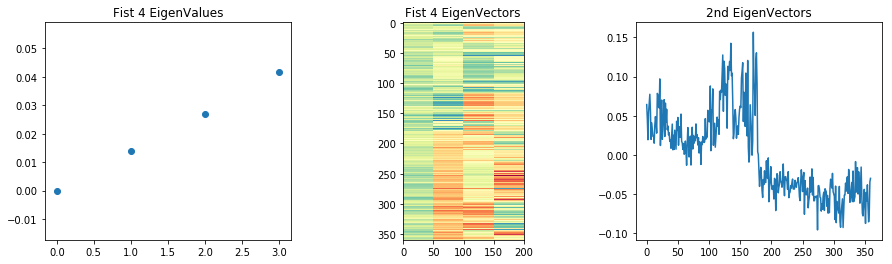

In [6]:
###Step 4: Spectral decomposition
from scipy.linalg import eigh
w, v = eigh(laplacian_matrix.todense()) # w = eigenvalues, v = eigenvectors

K_eigbasis = min(4,num_nodes)
fig=plt.figure(figsize=(15,4))
fig.add_subplot(131)
plt.scatter(range(K_eigbasis),w[:K_eigbasis])
plt.title("Fist {} EigenValues".format(K_eigbasis))

fig.add_subplot(132)
plt.imshow(np.repeat(v[:,:K_eigbasis],50,axis=1), cmap="Spectral")
plt.title("Fist {} EigenVectors".format(K_eigbasis))

fig.add_subplot(133)
plt.plot(v[:,1])
plt.title("2nd EigenVectors")

/home/yzhang/miniconda3/envs/tensorflow-py3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


[[1.         0.97801929]
 [0.97801929 1.        ]]


/home/yzhang/miniconda3/envs/tensorflow-py3.6/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


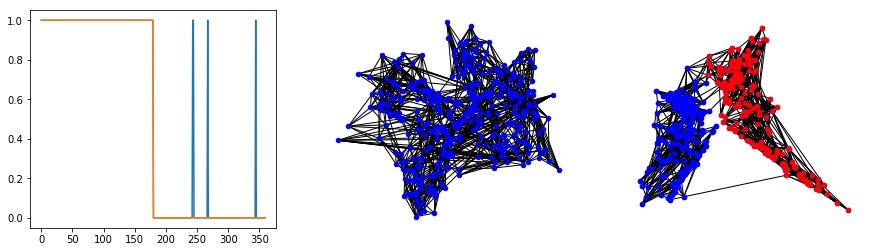

In [7]:
##Example #1: mapping 2nd and 3rd eigvectors and spectral clustering

##spectral clustering from sklearn
from sklearn import cluster
sp_clustering = cluster.SpectralClustering(n_clusters=2,eigen_solver='arpack',affinity='precomputed',
                                   assign_labels="discretize",random_state=1234).fit(corr_matrix_z)
sp_clustering.labels_

##spectral clustering: applying k-means to first k eigenvectors
sk_clustering = cluster.KMeans(n_clusters=2, random_state=1234).fit(v[:,:K_eigbasis])
sk_clustering.labels_
clusters = np.array([sp_clustering.labels_,sk_clustering.labels_]).transpose()
print(np.corrcoef(sp_clustering.labels_,sk_clustering.labels_))

fig=plt.figure(figsize=(15,4))
fig.add_subplot(131)
plt.plot(clusters)

##visualize the graph architecture
import networkx as nx
graph = nx.from_scipy_sparse_matrix(adj_mat_sp, parallel_edges=False, create_using=None, edge_attribute='weight')
pos = nx.spring_layout(graph) 
fig.add_subplot(132)
nx.draw(graph, pos, node_size=20, node_color='b')

pos = {i : (v[i,1], v[i,2]) for i in range(num_nodes)}
fig.add_subplot(133)
# set of nodes
nx.draw(graph, pos, node_size=20, node_color='b')
nx.draw_networkx_nodes(graph, pos, 
                       nodelist=list(np.where(sk_clustering.labels_==1)[0]),
                       node_color='r',node_size=20)
nx.draw_networkx_nodes(graph, pos, 
                       nodelist=list(np.where(sk_clustering.labels_==0)[0]),
                       node_color='b',node_size=20,)
plt.show()

In [8]:
##Example #2: brain decoding using graph convolutional networks
def extract_event_data(events_all_subjects_file,Trial_Num=None):
    ### loading event designs
    if not Trial_Num:
        Trial_Num = 284
    if not os.path.isfile(events_all_subjects_file):
        print("event file not exist:", events_all_subjects_file)
        return None
    
    print('Collecting trial info from file:', events_all_subjects_file)
    subjects_trial_labels = pd.read_csv(events_all_subjects_file,sep="\t",encoding="utf8")
    ###print(subjects_trial_labels.keys())

    try:
        label_matrix = subjects_trial_labels['label_data'].values
        print(subjects_trial_labels.shape)
        #xx = label_matrix[0].split(",")
        subjects_trial_label_matrix = []
        for subi in range(len(label_matrix)):
            xx = [x.replace("['", "").replace("']", "") for x in label_matrix[subi].split("', '")]
            subjects_trial_label_matrix.append(xx)
        subjects_trial_label_matrix = pd.DataFrame(data=(subjects_trial_label_matrix))
    except:
        subjects_trial_label_matrix = subjects_trial_labels.loc[:, 'trial1':'trial' + str(Trial_Num)]
    #subjects_trial_label_matrix = subjects_trial_labels.values.tolist()
    trialID = subjects_trial_labels['trialID']
    sub_name = subjects_trial_labels['subject'].tolist()
    coding_direct = subjects_trial_labels['coding']
    #print(np.array(subjects_trial_label_matrix).shape,len(sub_name),len(np.unique(sub_name)),len(coding_direct))
    
    return subjects_trial_label_matrix, trialID, sub_name, coding_direct

def load_fmri_data_from_lmdb(lmdb_filename,fmri_files=None,fmri_data_clean=None, write_frequency=10):
    ##lmdb_filename = pathout + modality + "_MMP_ROI_act_1200R_test_Dec2018_ALL.lmdb"
    ## read lmdb matrix
    import lmdb
    from tensorpack.utils.serialize import dumps, loads
    print('loading data from file: %s' % lmdb_filename)
    matrix_dict = []
    fmri_sub_name = []

    ##########################################33
    lmdb_env = lmdb.open(lmdb_filename, subdir=False)
    try:
        lmdb_txn = lmdb_env.begin()
        listed_fmri_files = loads(lmdb_txn.get(b'__keys__'))
        listed_fmri_files = [l.decode("utf-8") for l in listed_fmri_files]
        print('Stored fmri data from files:')
        print(len(listed_fmri_files))
    except:
        print('Search each key for every fmri file...')


    with lmdb_env.begin() as lmdb_txn:
        cursor = lmdb_txn.cursor()
        for key, value in cursor:
            # print(key)
            if key == b'__keys__':
                continue
            pathsub = Path(os.path.dirname(key.decode("utf-8")))
            ##subname_info = os.path.basename(key.decode("utf-8")).split('_')
            ##fmri_sub_name.append('_'.join((subname_info[0], subname_info[2], subname_info[3])))
            #############change due to directory switch to projects
            subname_info = str(Path(os.path.dirname(key.decode("utf-8"))).parts[-3])
            fmri_sub_name.append(Path(os.path.dirname(key.decode("utf-8"))).parts[-1].replace('tfMRI',subname_info))
            data = loads(lmdb_txn.get(key)).astype('float32', casting='same_kind')
            matrix_dict.append(np.array(data))
    lmdb_env.close()

    return matrix_dict, fmri_sub_name


### loading fmri data and event design

loading data from file: ../data/MOTOR_MMP_ROI_act_test_sub100.lmdb
Search each key for every fmri file...
(100, 284, 360) (100, 284)


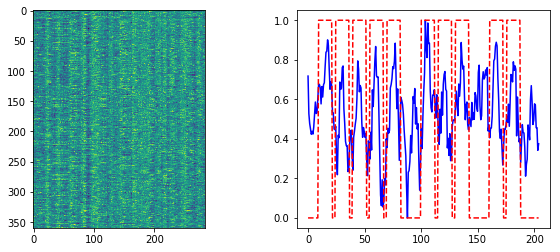

In [10]:

#step1: load fmri data

fmri_file = "../data/MOTOR_MMP_ROI_act_test_sub100.lmdb"
event_file = "../data/MOTOR_event_labels_test_sub100_newLR.h5"

sub100_tc_matrix, subname100 = load_fmri_data_from_lmdb(fmri_file)
sub100_trial_labels, sub100_trialID, sub100_sub_name, sub100_coding_direct = extract_event_data(event_file)
print(np.array(sub100_tc_matrix).shape,np.array(sub100_trial_labels).shape)

Subject_Num = np.array(sub100_tc_matrix).shape[0]
Trial_Num = np.array(sub100_tc_matrix).shape[1]
TR = 0.72

tc_roi_matrix = sub100_tc_matrix[0].transpose()
event_design = sub100_trial_labels.iloc[0]
event_select = np.zeros((Trial_Num,1))
for ei in np.where(event_design!='rest'):
    event_select[ei]=1

##plot regional tc aligned with event design
region_index = np.argsort(tc_roi_matrix.var(axis=-1))
tc_roi_matrix_sort = [tc_roi_matrix[ii,:] for ii in region_index]
event_time = np.arange(Trial_Num)*TR

fig=plt.figure(figsize=(10,4))
fig.add_subplot(121)
plt.imshow(tc_roi_matrix_sort)

fig.add_subplot(122)
fmri_tc = preprocessing.MinMaxScaler().fit_transform(tc_roi_matrix[region_index[350],:].reshape(-1,1))
plt.plot(event_time,fmri_tc,'b')
plt.plot(event_time, event_select,'r--')

(10, 360)


/home/yzhang/miniconda3/envs/tensorflow-py3.6/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


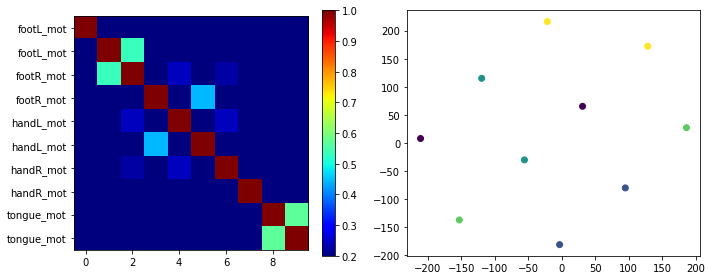

In [11]:
####build the label and data matrix
#print(task_contrasts)
task_contrasts = ['footL_mot','footR_mot','handL_mot','handR_mot','tongue_mot']
le = preprocessing.LabelEncoder()
le.fit(task_contrasts)
label_trial_task = np.array(le.transform(event_design[event_design!='rest']))
label_trial_task = np.array(np.split(label_trial_task, np.where(np.diff(label_trial_task))[0] + 1))[:,0]
task_idx = np.argsort(label_trial_task)
task_names = [le.inverse_transform(label_trial_task)[idx] for idx in task_idx]

###extract BOLD signals according to trial info
event_trial_block = np.split(event_select.astype(int), np.where(np.diff(event_select.astype(int),axis=0))[0] + 1)
fmri_trial_block = np.split(tc_roi_matrix, np.where(np.diff(event_select.astype(int),axis=0))[0] + 1,axis=-1)


fmri_trial_task = []
for ii in range(len(event_trial_block)):
    if np.unique(event_trial_block[ii]) !=0 :
        ##print(fmri_trial_block[ii].shape)
        fmri_trial_task.append(fmri_trial_block[ii].mean(axis=-1))
fmri_trial_task = np.array(fmri_trial_task)
print(fmri_trial_task.shape)
fig=plt.figure(figsize=(10,4))
fig.add_subplot(121)

correlation = np.corrcoef([fmri_trial_task[idx,:] for idx in task_idx])
plt.imshow(correlation, cmap="jet",vmin=0.2, vmax=1.0)
plt.yticks(np.arange(10), task_names)
plt.colorbar()
            
###map BOLD signals to 2d space  
tsne = manifold.TSNE(n_components=2, init='pca', random_state=1234, n_iter=10000)
output_2d = tsne.fit_transform(fmri_trial_task)
fig.add_subplot(122)
plt.scatter(output_2d[:, 0], output_2d[:, 1], c=label_trial_task)
plt.tight_layout()
plt.show()


### graph fourier transform:  L(x)=U'x

(20, 284)
(10, 340)


Text(0.5, 1.0, 'High freq graph mode')

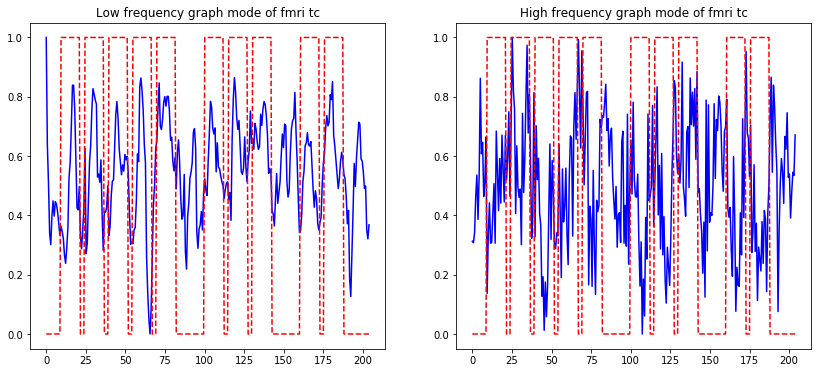

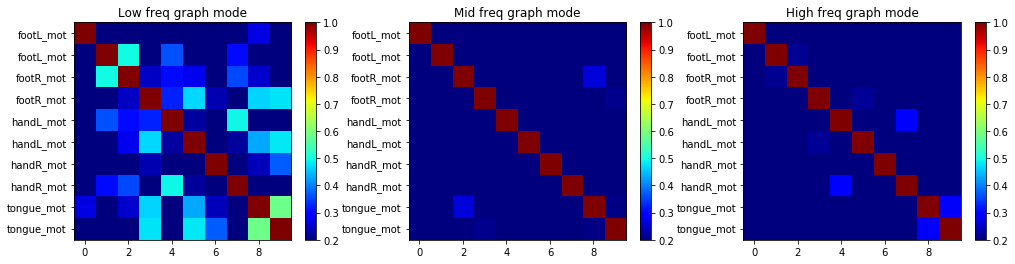

In [12]:
##graph fourier transform:  L(x)=U'x
low_mode = v[:,0]
low_mode = np.matmul(tc_roi_matrix.T,low_mode)
high_mode = v[:,-1]
high_mode = np.matmul(tc_roi_matrix.T,high_mode)

fig=plt.figure(figsize=(14,6))
fig.add_subplot(121)
fmri_tc = preprocessing.MinMaxScaler().fit_transform(low_mode.reshape(-1,1))
plt.plot(event_time,fmri_tc,'b')
plt.plot(event_time, event_select,'r--')
plt.title('Low frequency graph mode of fmri tc')

fig.add_subplot(122)
fmri_tc = preprocessing.MinMaxScaler().fit_transform(high_mode.reshape(-1,1))
plt.plot(event_time,fmri_tc,'b')
plt.plot(event_time, event_select,'r--')
plt.title('High frequency graph mode of fmri tc')

###nonlinear mapping
kmodes=20
laplacian_mode1 = np.matmul(tc_roi_matrix.T,v[:,1:kmodes+1]).transpose()
laplacian_mode2 = np.matmul(tc_roi_matrix.T,v[:,100:100+kmodes]).transpose()
laplacian_mode3 = np.matmul(tc_roi_matrix.T,v[:,kmodes:]).transpose()

print(laplacian_mode1.shape)
###extract BOLD signals according to trial info
event_trial_block = np.split(event_select.astype(int), np.where(np.diff(event_select.astype(int),axis=0))[0] + 1)
fmri_trial_block = np.split(laplacian_mode1, np.where(np.diff(event_select.astype(int),axis=0))[0] + 1,axis=-1)
fmri_trial_task = []
for ii in range(len(event_trial_block)):
    if np.unique(event_trial_block[ii]) !=0 :
        fmri_trial_task.append(fmri_trial_block[ii].flatten())
fmri_trial_task = np.array(fmri_trial_task)
print(fmri_trial_task.shape)

fig=plt.figure(figsize=(17,4))
fig.add_subplot(131)
correlation = np.corrcoef([fmri_trial_task[idx,:] for idx in task_idx])
plt.imshow(correlation, cmap="jet",vmin=0.2, vmax=1.0)
plt.yticks(np.arange(10), task_names)
plt.colorbar()
plt.title("Low freq graph mode")

fmri_trial_block = np.split(laplacian_mode2, np.where(np.diff(event_select.astype(int),axis=0))[0] + 1,axis=-1)
fmri_trial_task = []
for ii in range(len(event_trial_block)):
    if np.unique(event_trial_block[ii]) !=0 :
        fmri_trial_task.append(fmri_trial_block[ii].flatten())
fmri_trial_task = np.array(fmri_trial_task)
fig.add_subplot(132)
correlation = np.corrcoef([fmri_trial_task[idx,:] for idx in task_idx])
plt.imshow(correlation, cmap="jet",vmin=0.2, vmax=1.0)
plt.yticks(np.arange(10), task_names)
plt.colorbar()
plt.title("Mid freq graph mode")

fmri_trial_block = np.split(laplacian_mode3, np.where(np.diff(event_select.astype(int),axis=0))[0] + 1,axis=-1)
fmri_trial_task = []
for ii in range(len(event_trial_block)):
    if np.unique(event_trial_block[ii]) !=0 :
        fmri_trial_task.append(fmri_trial_block[ii].flatten())
fmri_trial_task = np.array(fmri_trial_task)
fig.add_subplot(133)
correlation = np.corrcoef([fmri_trial_task[idx,:] for idx in task_idx])
plt.imshow(correlation, cmap="jet",vmin=0.2, vmax=1.0)
plt.yticks(np.arange(10), task_names)
plt.colorbar()
plt.title("High freq graph mode")

### Next we going to explore GCN, which automatically learns a combination of graph modes
First, we need to build a dataset and dataloader to load fmri data
### dataset in pytorch includes three parts: _init_(); _len_(); _get_item()
second, we need our own version of collect-smaples function
### smaple-collect-fn: input: data, output: fmri-data and event-labels

In [13]:
##data loader: _init_(); _len_(); _get_item()
from torch.utils.data import Dataset, DataLoader

class HCP_taskfmri_matrix_datasets(Dataset):
    ##build a new class for own dataset
    
    def __init__(self, fmri_data_matrix, label_matrix, target_name,
                 isTrain='train', block_dura=1, transform=False):
        super(HCP_taskfmri_matrix_datasets, self).__init__()
        if not isinstance(fmri_data_matrix, np.ndarray):
            self.fmri_data_matrix = np.array(fmri_data_matrix)
        else:
            self.fmri_data_matrix = fmri_data_matrix
        
        self.Subject_Num = self.fmri_data_matrix.shape[0]
        self.Region_Num = self.fmri_data_matrix[0].shape[-1]

        if isinstance(label_matrix, pd.DataFrame):
            self.label_matrix = label_matrix
        elif isinstance(label_matrix, np.ndarray):
            self.label_matrix = pd.DataFrame(data=np.array(label_matrix))
        self.target_names = target_name

        self.block_dura = block_dura
        self.data_type = isTrain
        self.transform = transform

    def __len__(self):
        return self.Subject_Num

    def __getitem__(self, idx):
        #step1: get one subject data
        fmri_trial_data = self.fmri_data_matrix[idx]
        label_trial_data = self.label_matrix.iloc[idx]


        ##step3: match fmri and event acoording to time
        fmri_data, label_data = self.match_fmri_event_data(fmri_trial_data, label_trial_data,self.block_dura)
        #print(fmri_data.shape, label_data.shape)
        Nsamples = fmri_data.shape[0]
        if self.transform:
            fmri_data_2d = fmri_data.reshape(Nsamples,-1)
            scaler = preprocessing.StandardScaler()
            fmri_data = scaler.fit_transform(fmri_data_2d).reshape(Nsamples,self.block_dura,self.Region_Num)
            #print(fmri_data.shape, label_data.shape)

        tensor_x = torch.stack([torch.FloatTensor(fmri_data[ii].transpose()) for ii in range(len(label_data))])  # transform to torch tensors
        tensor_y = torch.stack([torch.LongTensor([label_data[ii]]) for ii in range(len(label_data))])

        return tensor_x, tensor_y

    def match_fmri_event_data(self,fmri_trial_data, label_trial_data,block_dura=1):
        ###matching between fmri data and event data
        condition_mask = pd.Series(label_trial_data).isin(self.target_names)
        tc_matrix_select = np.array(fmri_trial_data[condition_mask, :])
        label_data_select = np.array(label_trial_data[condition_mask])
        ##print(tc_matrix_select.shape,label_data_select.shape)

        le = preprocessing.LabelEncoder()
        le.fit(list(self.target_names))
        label_data_int = le.transform(label_data_select)

        ##cut the trials
        label_data_trial_block = np.array(np.split(label_data_select, np.where(np.diff(label_data_int))[0] + 1))
        fmri_data_block = np.array(np.array_split(tc_matrix_select, np.where(np.diff(label_data_int))[0] + 1, axis=0))

        trial_duras = [label_data_trial_block[ii].shape[0] for ii in range(len(label_data_trial_block))]
        ##cut each trial to blocks
        fmri_data_block_new = []
        label_data_trial_block_new = []
        for ti, dura in enumerate(trial_duras):
            if dura < block_dura:  ##one sample per each trial
                trial_num_used = min(dura, block_dura)
                xx = fmri_data_block[ti][:trial_num_used, :]
                xx2 = np.expand_dims(xx.take(range(0, block_dura), axis=0, mode='clip'), axis=0)
                yy = np.array([label_data_trial_block[ti][0]])
            else:  ##multiple samples from one trial
                trial_num_used = dura // block_dura * block_dura
                chunks = int(np.floor(trial_num_used // block_dura))
                xx2 = np.array(np.array_split(fmri_data_block[ti][:trial_num_used, :], chunks, axis=0))
                yy = np.array(np.array_split(label_data_trial_block[ti][:trial_num_used], chunks, axis=0))[:, 0]

            fmri_data_block_new.append(xx2)
            label_data_trial_block_new.append(yy)
        label_data_matrix = np.concatenate(label_data_trial_block_new, axis=0)
        fmri_data_matrix = np.array(np.vstack(fmri_data_block_new)).astype('float32', casting='same_kind')

        return fmri_data_matrix, le.transform(label_data_matrix)
    
def fmri_samples_collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    images, targets = zip(*data)
    
    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.FloatTensor(torch.cat(images)) #.permute(0, 2, 1)
    targets = torch.LongTensor(torch.cat(targets).squeeze())
    #images = images.view(-1,np.prod(images.shape[1:]))

    #Nsamples = len(targets)
    #rand_slice = np.random.choice(Nsamples, 1, replace=False)
    #print(images.shape, targets.shape)
    
    return images, targets

In [14]:
modality='MOTOR'
task_contrasts = {"rf": "footR_mot",
                  "lf": "footL_mot",
                  "rh": "handR_mot",
                  "lh": "handL_mot",
                  "t": "tongue_mot"}
params = {'batch_size': 2,
          'shuffle': True,
          'num_workers': 1}

target_name = (list(task_contrasts.values()))
print(target_name)
Nlabels = len(target_name) + 1
fmri_train_dataset = HCP_taskfmri_matrix_datasets(sub100_tc_matrix, sub100_trial_labels, target_name, block_dura=17, isTrain='train')
                
train_loader = DataLoader(fmri_train_dataset, collate_fn=fmri_samples_collate_fn, **params)
data,label = next(iter(train_loader))
print(data.shape,label.shape)

['footR_mot', 'footL_mot', 'handR_mot', 'handL_mot', 'tongue_mot']
torch.Size([20, 360, 17]) torch.Size([20])


### split the entire dataset into train and test tests
training on 80% of subjects and test on the rest 20% subjects

In [15]:
###split the entire dataset into train and test tests
###############################
params = {'batch_size': 2,
          'shuffle': True,
          'num_workers': 2}

Region_Num = sub100_tc_matrix[0].shape[-1]
block_dura = 17    
test_size = 0.2
randomseed=1234

test_sub_num = len(sub100_tc_matrix)
rs = np.random.RandomState(randomseed)
train_sid, test_sid = train_test_split(range(test_sub_num), test_size=test_size, random_state=rs, shuffle=True)
print('training on %d subjects, validating on %d subjects' % (len(train_sid), len(test_sid)))

####train set
fmri_data_train = [sub100_tc_matrix[i] for i in train_sid]
label_data_train = pd.DataFrame(np.array([sub100_trial_labels.iloc[i] for i in train_sid]))
fmri_train_dataset = HCP_taskfmri_matrix_datasets(fmri_data_train, label_data_train, target_name, block_dura=17, isTrain='train')
train_loader = DataLoader(fmri_train_dataset, collate_fn=fmri_samples_collate_fn, **params)

####test set
fmri_data_test = [sub100_tc_matrix[i] for i in test_sid]
label_data_test = pd.DataFrame(np.array([sub100_trial_labels.iloc[i] for i in test_sid]))
fmri_test_dataset = HCP_taskfmri_matrix_datasets(fmri_data_test, label_data_test, target_name, block_dura=17, isTrain='test')
test_loader = DataLoader(fmri_test_dataset, collate_fn=fmri_samples_collate_fn, **params)

training on 80 subjects, validating on 20 subjects


In [16]:
########a few useful functions
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

##training the model
def train(model,device,train_loader,optimizer, epoch):
    model.train()

    acc = 0.
    train_loss = 0.
    total = 0
    t0 = time.time()
    for batch_idx, (data,target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        out = model(data,adj_mat)
        loss = loss_func(out,target)
        pred = F.log_softmax(out, dim=1).argmax(dim=1)

        total += target.size(0)
        train_loss += loss.sum().item()
        acc += pred.eq(target.view_as(pred)).sum().item()
        
        loss.backward()
        optimizer.step()
        
    print("\nEpoch {}: \nTime Usage:{:4f} | Training Loss {:4f} | Acc {:4f}".format(epoch,time.time()-t0,train_loss/total,acc/total))
    return train_loss/total,acc/total

def test(model,device, test_loader):
    model.eval()
    test_loss=0.
    test_acc = 0.
    total = 0
    ##no gradient desend for testing
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            out = model(data,adj_mat)
            
            loss = loss_func(out,target)
            test_loss += loss.sum().item()
            pred = F.log_softmax(out, dim=1).argmax(dim=1)
            #pred = out.argmax(dim=1,keepdim=True) # get the index of the max log-probability
            total += target.size(0)
            test_acc += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= total
    test_acc /= total
    print('Test Loss {:4f} | Acc {:4f}'.format(test_loss,test_acc))
    return test_loss,test_acc

def plot_history(model_history):
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.plot(model_history['train_acc'], color='r')
    plt.plot(model_history['test_acc'], color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Prediction Accuracy')
    plt.legend(['Training', 'Validation'])

    plt.subplot(122)
    plt.plot(model_history['train_loss'], color='r')
    plt.plot(model_history['test_loss'], color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Function')
    plt.legend(['Training', 'Validation'])

    
def model_fit_evaluate(model,device,train_loader,test_loader,optimizer,num_epochs=100):
    best_acc = 0 
    model_history={}
    model_history['train_loss']=[];
    model_history['train_acc']=[];
    model_history['test_loss']=[];
    model_history['test_acc']=[];  
    for epoch in range(num_epochs):
        train_loss,train_acc =train(model, device, train_loader, optimizer,epoch)
        model_history['train_loss'].append(train_loss)
        model_history['train_acc'].append(train_acc)

        test_loss,test_acc = test(model, device, test_loader)
        model_history['test_loss'].append(test_loss)
        model_history['test_acc'].append(test_acc)
        if test_acc > best_acc:
            best_acc = test_acc
            print("Model updated: Best-Acc = {:4f}".format(best_acc))

    print("best testing accuarcy:",best_acc)
    plot_history(model_history)
    


### first we test on a simple 2-layer MLP

cpu
FCN(
  (linear): Linear(in_features=360, out_features=128, bias=True)
  (hidden2label): Linear(in_features=128, out_features=6, bias=True)
)
46982 paramters to be trained in the model


Epoch 0: 
Time Usage:0.412288 | Training Loss 0.075193 | Acc 0.418750
Test Loss 0.063279 | Acc 0.565000
Model updated: Best-Acc = 0.565000

Epoch 1: 
Time Usage:0.357587 | Training Loss 0.049974 | Acc 0.698750
Test Loss 0.047567 | Acc 0.700000
Model updated: Best-Acc = 0.700000

Epoch 2: 
Time Usage:0.382509 | Training Loss 0.034880 | Acc 0.812500
Test Loss 0.037451 | Acc 0.770000
Model updated: Best-Acc = 0.770000

Epoch 3: 
Time Usage:0.364618 | Training Loss 0.023989 | Acc 0.895000
Test Loss 0.030421 | Acc 0.825000
Model updated: Best-Acc = 0.825000

Epoch 4: 
Time Usage:0.356621 | Training Loss 0.016802 | Acc 0.938750
Test Loss 0.026522 | Acc 0.805000

Epoch 5: 
Time Usage:0.371926 | Training Loss 0.012324 | Acc 0.960000
Test Loss 0.022994 | Acc 0.840000
Model updated: Best-Acc = 0.840000

Epoch

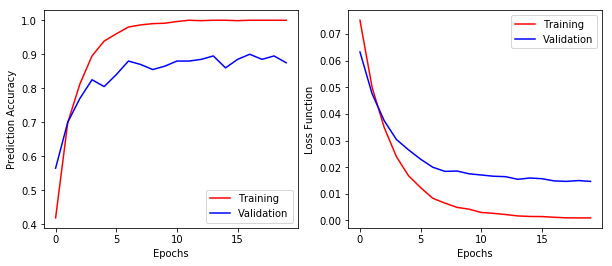

In [18]:
class FCN(nn.Module):
###fully-connected
    def __init__(self, input_dim, output_dim,hidden_dim=128, dropout=0.2):
        super(FCN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.dropout = dropout

        # Define the output layer
        self.linear = nn.Linear(self.input_dim, hidden_dim)

        self.hidden2label = nn.Linear(hidden_dim, self.output_dim)

    def forward(self, inputs, adj=None):
        if len(inputs.size())>2:
            ###average across all channels
            inputs = torch.mean(inputs, dim=-1)

        x = F.relu(self.linear(inputs))
        x = F.dropout(x, training=self.training,p=self.dropout)
        y_pred = self.hidden2label(x)
        return y_pred

###fully-connected
#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)

model = FCN(Region_Num, Nlabels)
model = model.to(device)
print(model)
print("{} paramters to be trained in the model\n".format(count_parameters(model)))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_func = nn.CrossEntropyLoss()
num_epochs=20

model_fit_evaluate(model,device,train_loader,test_loader,optimizer,num_epochs)

### Next, we tried with graph convolutional networks
there are two versions we test here: 1stGCN and ChebyNet;
#We will see the power of including higher k-orders

In [19]:
class GraphConv(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    math:
      Z = D(-1/2)AstarD(-1/2)X; Astar=I+A
    Args:
        in_channels (int): Size of each input sample.
        out_channels (int): Size of each output sample.
        K (int): Chebyshev filter size, *i.e.* number of hops :math:`K`.
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
    """


    def __init__(self, in_features, out_features, bias=True):
        super(GraphConv, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        ####initialize all layer parameters
        self.initialize_parameters()

    def initialize_parameters(self):
        nn.init.kaiming_normal_(self.weight.data, a=0, mode='fan_in')
        if self.bias is not None:
            nn.init.constant_(self.bias.data, 0.0)

    def forward(self,  x, edge_index, edge_weight=None):
        batch, num_nodes = x.size(0), x.size(1)
        ##first adjust the adj matrix with diag elements
        edge_index, edge_weight = add_self_loops(edge_index, edge_weight, 1, num_nodes)
        row, col = edge_index
        
        edge_weight = edge_weight.view(-1)
        assert edge_weight.size(0) == edge_index.size(1)
        
        ###degree matrix
        deg = scatter_add(edge_weight, row, dim=0, dim_size=num_nodes)
        # Compute normalized and rescaled Laplacian.
        deg = deg.pow(-0.5)
        deg[torch.isinf(deg)] = 0
        lap = deg[row] * edge_weight * deg[col]
        ###Rescale the Laplacian eigenvalues in [-1, 1]
        #fill_value = 0.05  ##-0.5
        #edge_index, lap = add_self_loops(edge_index, lap, fill_value, num_nodes)

        x = torch.matmul(x, self.weight)
        out = spmm(edge_index, lap, num_nodes, x.permute(1, 2, 0).contiguous().view((num_nodes, -1))).view((num_nodes, -1, batch)).permute(2, 0,1)  # spmm(edge_index, lap, num_nodes, x)

        if self.bias is not None:
            out = out + self.bias

        return out
    
    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'
    
class ChebConv(nn.Module):
    """The chebyshev spectral graph convolutional operator
    .. math::
        \mathbf{Z}^{(0)} &= \mathbf{X}

        \mathbf{Z}^{(1)} &= \mathbf{\hat{L}} \cdot \mathbf{X}

        \mathbf{Z}^{(k)} &= 2 \cdot \mathbf{\hat{L}} \cdot
        \mathbf{Z}^{(k-1)} - \mathbf{Z}^{(k-2)}

    and :math:`\mathbf{\hat{L}}` denotes the scaled and normalized Laplacian.

    Args:
        in_channels (int): Size of each input sample.
        out_channels (int): Size of each output sample.
        K (int): Chebyshev filter size, *i.e.* number of hops :math:`K`.
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
    """

    def __init__(self, in_channels, out_channels, K, bias=True):
        super(ChebConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.weight = nn.Parameter(torch.FloatTensor(K+1, in_channels, out_channels))

        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_channels))
        else:
            self.register_parameter('bias', None)
        ####initialize all layer parameters
        self.initialize_parameters()

    def initialize_parameters(self):
        nn.init.kaiming_normal_(self.weight.data, a=0, mode='fan_in')
        if self.bias is not None:
            nn.init.constant_(self.bias.data, 0.0)

    def forward(self, x, edge_index, edge_weight=None):
        """"""
        # edge_index, edge_weight = remove_self_loops(edge_index, edge_weight)
        # print(x.size(), edge_index.size())
        row, col = edge_index
        batch, num_nodes, num_edges, K = x.size(0), x.size(1), row.size(0), self.weight.size(0)
            
        edge_weight = edge_weight.view(-1)
        assert edge_weight.size(0) == edge_index.size(1)
        
        ###degree matrix
        deg = scatter_add(edge_weight, row, dim=0, dim_size=num_nodes)
        # Compute normalized and rescaled Laplacian.
        deg = deg.pow(-0.5)
        deg[torch.isinf(deg)] = 0
        lap = -deg[row] * edge_weight * deg[col]
        ###Rescale the Laplacian eigenvalues in [-1, 1]
        ##rescale: 2L/lmax-I; lmax=1.0
        fill_value = -0.05  ##-0.5
        edge_index, lap = add_self_loops(edge_index, lap, fill_value, num_nodes)
        lap *= 2

        ########################################
        # Perform filter operation recurrently.
        Tx_0 = x
        out = torch.matmul(Tx_0, self.weight[0])
        if K > 1:
            Tx_1 = spmm(edge_index, lap, num_nodes, x.permute(1, 2, 0).contiguous().view((num_nodes, -1))).view((num_nodes, -1, batch)).permute(2, 0,1)  # spmm(edge_index, lap, num_nodes, x)
            out = out + torch.matmul(Tx_1, self.weight[1])

        for k in range(2, K):
            Tx_2 = 2 * spmm(edge_index, lap, num_nodes, x.permute(1, 2, 0).contiguous().view((num_nodes, -1))).view((num_nodes, -1, batch)).permute(2,0,1) - Tx_0
            # 2 * spmm(edge_index, lap, num_nodes, Tx_1) - Tx_0
            out = out + torch.matmul(Tx_2, self.weight[k])
            Tx_0, Tx_1 = Tx_1, Tx_2

        if self.bias is not None:
            out = out + self.bias

        return out

    def __repr__(self):
        return '{}({}, {}, K={})'.format(self.__class__.__name__, self.in_channels, self.out_channels, self.weight.size(0)-1)

    
class ChebNet(nn.Module):
    def __init__(self, nfeat, nfilters, nclass, K=2, nodes=360, nhid=128, gcn_layer=2, dropout=0, gcn_flag=False):
        super(ChebNet, self).__init__()
        self.gcn_layer = gcn_layer

        ####feature extracter
        self.graph_features = nn.ModuleList()
        if gcn_flag is True:
            print('Using GCN Layers instead')
            self.graph_features.append(GraphConv(nfeat, nfilters))
        else:
            self.graph_features.append(ChebConv(nfeat, nfilters, K))
        for i in range(gcn_layer):
            if gcn_flag is True:
                self.graph_features.append(GraphConv(nfilters, nfilters))
            else:
                self.graph_features.append(ChebConv(nfilters, nfilters, K))


        if dropout > 0:
            self.dropout = nn.Dropout(dropout)
        else:
            self.dropout = nn.Identity(dropout)

        # Define the output layer
        self.graph_nodes = nodes
        self.hidden_size = self.graph_nodes
        self.pool = nn.AdaptiveMaxPool2d((self.hidden_size,1))

        self.linear = nn.Linear(self.hidden_size, nclass)
        self.hidden2label = nn.Sequential(
            nn.Linear(self.hidden_size, nhid),
            nn.ReLU(True),
            nn.Dropout(p=0.25),
            nn.Linear(nhid, nhid // 4),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(nhid // 4, nclass),
        )

    def forward(self, inputs, adj_mat):
        edge_index = adj_mat._indices()
        edge_weight = adj_mat._values()
        batch = inputs.size(0)
        ###gcn layer
        x = inputs
        for layer in self.graph_features:
            x = F.relu(layer(x, edge_index, edge_weight))
            x = self.dropout(x)
        x = self.pool(x)
        ###linear dense layer
        # y_pred = self.linear(x.view(batch,-1))
        y_pred = self.hidden2label(x.view(batch, -1))
        return y_pred


<>:80: DeprecationWarning: invalid escape sequence \m


Using GCN Layers instead
ChebNet(
  (graph_features): ModuleList(
    (0): GraphConv (17 -> 32)
    (1): GraphConv (32 -> 32)
    (2): GraphConv (32 -> 32)
  )
  (dropout): Dropout(p=0.25)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=6, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace)
    (2): Dropout(p=0.25)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace)
    (5): Dropout(p=0.5)
    (6): Linear(in_features=32, out_features=6, bias=True)
  )
)
55388 paramters to be trained in the model


Epoch 0: 
Time Usage:16.763911 | Training Loss 0.085822 | Acc 0.208750
Test Loss 0.083625 | Acc 0.200000
Model updated: Best-Acc=0.200000

Epoch 1: 
Time Usage:16.279265 | Training Loss 0.083859 | Acc 0.213750
Test Loss 0.081267 | Acc 0.245000
Model updated: Best-Acc=0.245000

Epoch 2: 
Time Usage:16.059735 | Training Loss 0.079595 | Acc 

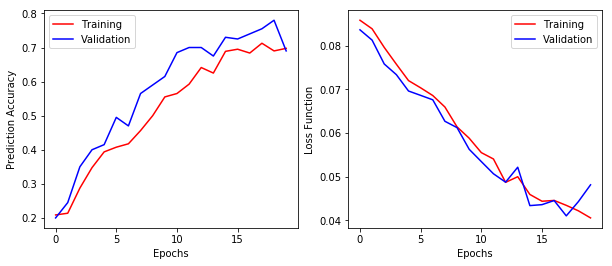

In [52]:
filters=32
num_layers=2
model_test = ChebNet(block_dura, filters, Nlabels, gcn_layer=num_layers,dropout=0.25,gcn_flag=True)
#model_test = ChebNet(block_dura, filters, Nlabels, K=5,gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test,device,train_loader,test_loader,optimizer,num_epochs)

ChebNet(
  (graph_features): ModuleList(
    (0): ChebConv(17, 32, K=5)
    (1): ChebConv(32, 32, K=5)
    (2): ChebConv(32, 32, K=5)
  )
  (dropout): Dropout(p=0.25)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=6, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace)
    (2): Dropout(p=0.25)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace)
    (5): Dropout(p=0.5)
    (6): Linear(in_features=32, out_features=6, bias=True)
  )
)
68348 paramters to be trained in the model


Epoch 0: 
Time Usage:42.372984 | Training Loss 0.086689 | Acc 0.221250
Test Loss 0.082802 | Acc 0.215000
Model updated: Best-Acc=0.215000

Epoch 1: 
Time Usage:43.559816 | Training Loss 0.084129 | Acc 0.195000
Test Loss 0.083035 | Acc 0.220000
Model updated: Best-Acc=0.220000

Epoch 2: 
Time Usage:40.217391 | Training Loss 0.082292 | Acc 0.221250
Test Loss 0.0

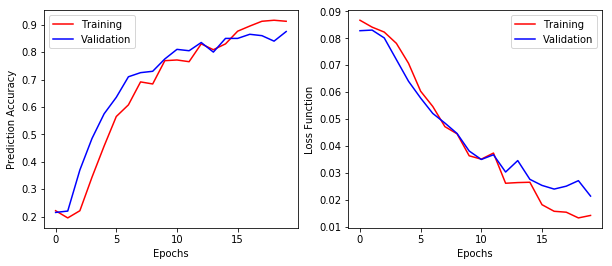

In [53]:
model_test = ChebNet(block_dura, filters, Nlabels, K=5,gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test,device,train_loader,test_loader,optimizer,num_epochs)